In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules
import better_plotting

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
# warnings.simplefilter("ignore")

from functools import partial
import scanpy as sc
import anndata

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso

In [2]:
invitro_df = pd.read_csv('gene_level_count_tmm_normalized_v2.csv', index_col='Gene Name')
invitro_df.loc['WARS'] = invitro_df.loc['WARS1']
invitro_df.loc['DDX58'] = invitro_df.loc['RIGI']
invitro_df = invitro_df.drop(['RIGI', 'WARS1'], axis=0)

invitro_df = invitro_df.drop(columns=['Unnamed: 0'])

In [3]:
invitro_df.columns = [
    '1021_V1',
    '1021_V2_a-IFNa',
    '1021_V2_a-IFNg_a-IFNa',
    '1021_V2',
    '1021_V5_a-IFNg_a-IFNa',
    '1021_V5_a-IFNg',
    '1021_V5',
    'IFNa_anti-IFNa',
    'IFNa',
    'IFNg_anti-IFNg',
    'IFNg_IFNa',
    'IFNg',
    'Medium', 
    'Undetermined'
]

In [4]:
genes_dict = {
	'High Specific' : ['APOL3', 'CAMK2D', 'DYSF', 'GBP1', 'GBP2', 'GBP5', 'LIMK2', 'MYOF', 'NCF1', 'PSMB9', 'WARS'],
	'High and Dim' : ['ADAR', 'DDX60', 'EPSTI1', 'IFI16', 'IFIH1', 'PARP14', 'PARP9', 'RNF213', 'STAT2', 'TRIM22'],
	'Dim Specific' : ['COA1', 'DDX58', 'EIF2AK2', 'IFI44', 'IFI44L', 'MX1', 'MX2', 'TENT5A'],
	# 'Dim and Low Shared' : ['LDLRAD4', 'NLRP12', 'SSBP2', 'TIAM1'],
}

short_df = invitro_df.loc[sum(genes_dict.values(), [])].copy()
short_df['Type'] = 'Other'
short_df['Gene'] = short_df.index

for type_, genes in genes_dict.items():
    for gene in genes:
        if gene in short_df.index:
            short_df.loc[gene, 'Type'] = type_

In [5]:
short_df.loc[:, 'a/g'] = (short_df['IFNa'] / (short_df['IFNg']))
short_df.loc[:, 'g/a'] = (short_df['IFNg'] / (short_df['IFNa']))

In [6]:
# short_df['a/g_fc'] = np.log1p(short_df['a/g'])
# short_df['g/a_fc'] = np.log1p(short_df['g/a'])

short_df['a/g_fc'] = np.log2(short_df['a/g'])
short_df['g/a_fc'] = np.log2(short_df['g/a'])


In [7]:
gene_palette = {
    'APOL3': 'k',
    'CAMK2D': 'k',
    'DYSF': 'k',
    'GBP1': 'k',
    'GBP2': 'red',
    'GBP5': 'k',
    'LIMK2': 'k',
    'MYOF': 'k',
    'NCF1': 'k',
    'PSMB9': 'k',
    'WARS': 'k',

    'ADAR' : 'green',
    'DDX60' : 'k',
    'EPSTI1' : 'k',
    'IFI16' : 'k',
    'IFIH1' : 'k',
    'PARP14' : 'k',
    'PARP9' : 'k',
    'RNF213' : 'k',
    'STAT2' : 'k',
    'TRIM22' : 'k',

    'COA1': 'k',
    'DDX58': 'k',
    'EIF2AK2': 'k',
    'IFI44': 'k',
    'IFI44L': 'k',
    'MX1': 'blue',
    'MX2': 'k',
    'TENT5A': 'k'
}

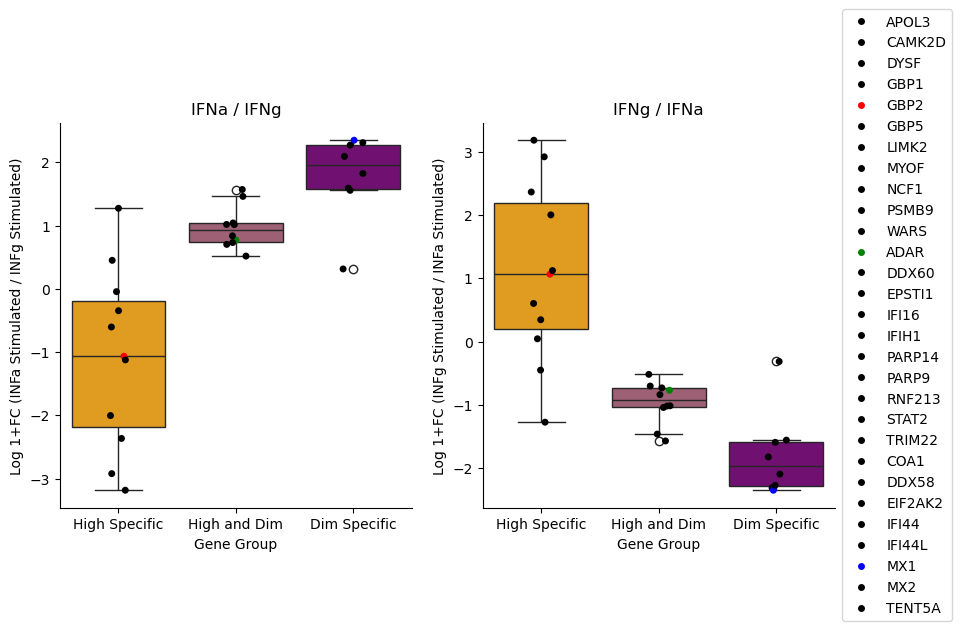

In [8]:
fig, axs = plt.subplots(ncols = 2, figsize = (10, 5))
p = {'High and Dim': '#A75670', 'Dim Specific': 'purple', 'High Specific': 'orange'}
sns.boxplot(short_df, x = 'Type', y = 'a/g_fc', hue = 'Type', palette=p, ax = axs[0])
# sns.stripplot(short_df, x = 'Type', y = 'a/g_fc', color = 'k', ax = axs[0])
sns.stripplot(short_df, x = 'Type', y = 'a/g_fc', hue = 'Gene', palette=gene_palette, ax = axs[0])
axs[0].get_legend().remove()

sns.boxplot(short_df, x = 'Type', y = 'g/a_fc', hue = 'Type', palette=p, ax = axs[1])
# sns.stripplot(short_df, x = 'Type', y = 'g/a_fc', color = 'k', ax = axs[1])
sns.stripplot(short_df, x = 'Type', y = 'g/a_fc', hue = 'Gene', palette=gene_palette, ax = axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axs[0].set_ylabel('Log 1+FC (INFa Stimulated / INFg Stimulated)'); axs[0].set_title('IFNa / IFNg')
axs[1].set_ylabel('Log 1+FC (INFg Stimulated / INFa Stimulated)'); axs[1].set_title('IFNg / IFNa')

for ax in axs:
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene Group')

# my_plotting.savefig_png_eps(fig, 'IFNa_IFNg_fc_box_plots', use_timestamp=False, make_folder=True)

In [9]:
hs = short_df.loc[genes_dict['High Specific'], 'a/g_fc']
ds = short_df.loc[genes_dict['Dim Specific'], 'a/g_fc']
stats.ttest_ind(hs, ds)

TtestResult(statistic=np.float64(-5.291401397920881), pvalue=np.float64(5.983518533545332e-05), df=np.float64(17.0))

In [10]:
adata = anndata.AnnData(invitro_df.T)
adata.var_names_make_unique()

adata.obs['Sample'] = pd.Categorical(adata.obs.index.values, categories =[
    '1021_V1',
    '1021_V2',
    '1021_V2_a-IFNa',
    '1021_V2_a-IFNg_a-IFNa',
    '1021_V5',
    '1021_V5_a-IFNg',
    '1021_V5_a-IFNg_a-IFNa',
    'IFNa_anti-IFNa',
    'IFNg_anti-IFNg',
    'IFNg_IFNa',
    'IFNg',
    'IFNa',
    'Medium', 
    'Undetermined'
])

/projects/ucar-lab/giray/miniconda3/envs/scanpy_1_10_4/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
our_cd14 = sc.read_h5ad(f'/projects/ucar-lab/giray/DOGMA-seq/Dogma-2/Restart from aggregated samples/data/subsets/level1/2/Monocyte CD14-2.h5ad')
our_cd14.obs['subsets'] = pd.Categorical(our_cd14.obs['new_subset_annotations_2'].map({
    'Monocyte CD14': 'CD14 ISG Low',
    'Monocyte CD14 ISG 1': 'CD14 ISG High',
    'Monocyte CD14 ISG 2': 'CD14 ISG High',
    'Monocyte CD14 ISG (Low)': 'CD14 ISG Dim',
    'Monocyte CD14 ISG Inflamm.': 'CD14 ISG High',
}),  categories=['CD14 ISG High', 'CD14 ISG Dim', 'CD14 ISG Low'])

our_cd14 = our_cd14.raw.to_adata()
our_cd14.layers['normalized'] = our_cd14.X.copy()


In [12]:
our_cd14.obs['subsets'] = our_cd14.obs['subsets'].cat.set_categories(['J&J CD14 ISG High', 'CD14 ISG High', 'CD14 ISG Dim', 'CD14 ISG Low'])
our_cd14.obs.loc[(our_cd14.obs['subsets'] == 'CD14 ISG High') & (our_cd14.obs['Vaccine'] == 'J&J'), 'subsets'] = 'J&J CD14 ISG High'
our_cd14.obs['subsets'] = our_cd14.obs['subsets'].cat.rename_categories({'CD14 ISG High' : 'mRNA CD14 ISG High'})

In [13]:
our_cd14_mrna = our_cd14[our_cd14.obs['Vaccine']!='J&J'].copy()

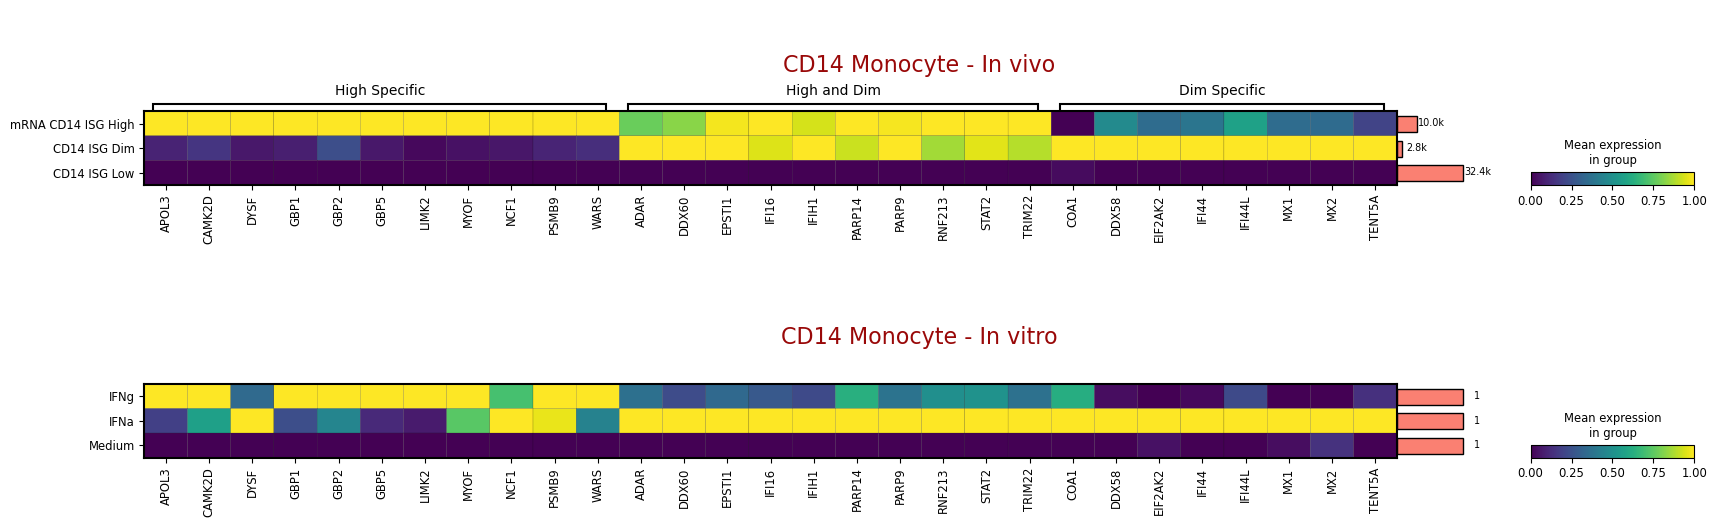

In [14]:
fig = plt.figure(figsize = (20, 5))
subfigs = fig.subfigures(nrows=2, wspace=0)


ax = subfigs[0].subplots()
mp = sc.pl.matrixplot(our_cd14_mrna, 
                      genes_dict, 
                      groupby = 'subsets', 
                      standard_scale = 'var',
                      return_fig=True,
                      var_group_rotation = 0,
                      ax = ax,
                      show = False
                     )
mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vivo', y = .6, fontsize=16, color = '#990808')
    # if ct != 'Naive CD8':
    #     mp.get_axes()['mainplot_ax'].set_xticklabels([])

ax = subfigs[1].subplots()
mp = sc.pl.matrixplot(adata[['IFNg', 'IFNa', 'Medium']], 
              sum(genes_dict.values(), []),
              groupby = 'Sample', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True,
              ax = ax
             )

mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vitro', y = .6, fontsize=16, color = '#990808')

fig = mp.fig


plt.show()

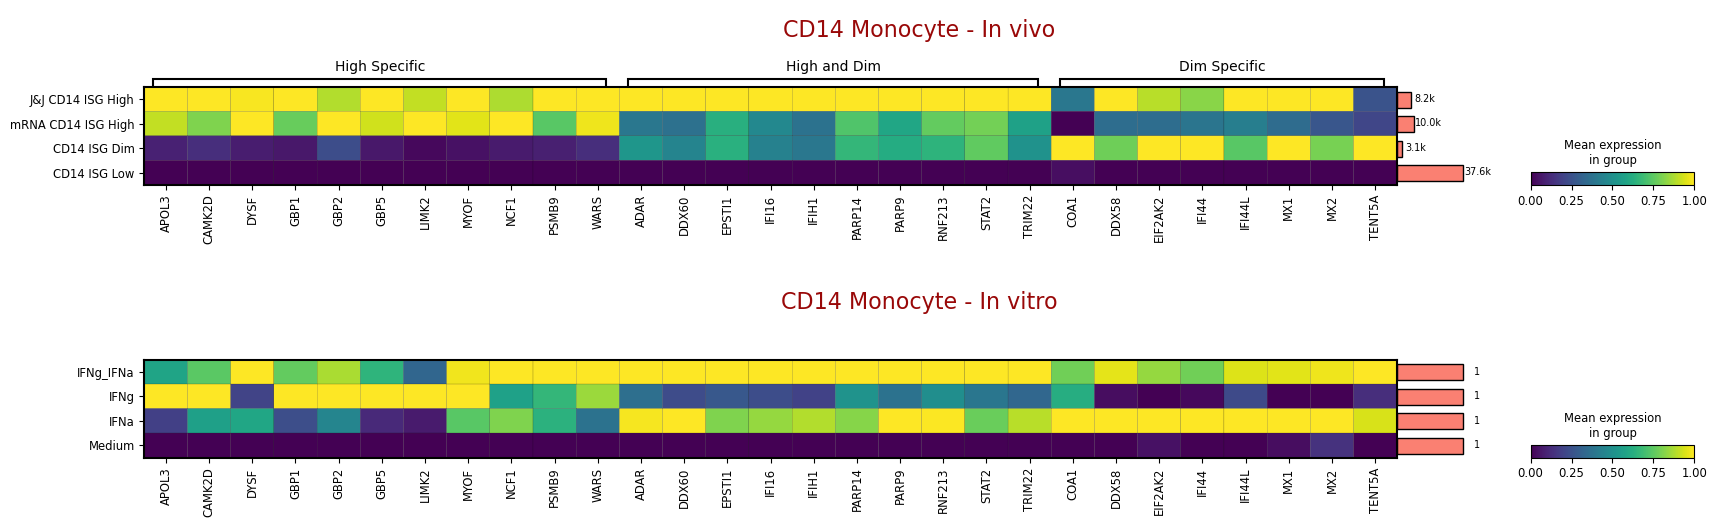

In [15]:
fig = plt.figure(figsize = (20, 5))
subfigs = fig.subfigures(nrows=2, wspace=0)


ax = subfigs[0].subplots()
mp = sc.pl.matrixplot(our_cd14, 
                      genes_dict, 
                      groupby = 'subsets', 
                      standard_scale = 'var',
                      return_fig=True,
                      var_group_rotation = 0,
                      ax = ax,
                      show = False
                     )
mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vivo', y = .8, fontsize=16, color = '#990808')
    # if ct != 'Naive CD8':
    #     mp.get_axes()['mainplot_ax'].set_xticklabels([])

ax = subfigs[1].subplots()
mp = sc.pl.matrixplot(adata[['IFNg_IFNa', 'IFNg', 'IFNa', 'Medium']], 
              sum(genes_dict.values(), []),
              groupby = 'Sample', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True,
              ax = ax
             )

mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vitro', y = .8, fontsize=16, color = '#990808')

fig = mp.fig


plt.show()

In [16]:
isg_dims = {
	# 'High Specific' : ['APOL3', 'CAMK2D', 'DYSF', 'GBP1', 'GBP2', 'GBP5', 'LIMK2', 'MYOF', 'NCF1', 'PSMB9', 'WARS'],
	# 'High and Dim' : ['ADAR', 'DDX60', 'EPSTI1', 'IFI16', 'IFIH1', 'PARP14', 'PARP9', 'RNF213', 'STAT2', 'TRIM22'],
	'Dim Specific' : ['COA1', 'DDX58', 'EIF2AK2', 'IFI44', 'IFI44L', 'MX1', 'MX2', 'TENT5A'],
	# 'Dim and Low Shared' : ['LDLRAD4', 'NLRP12', 'SSBP2', 'TIAM1'],
}

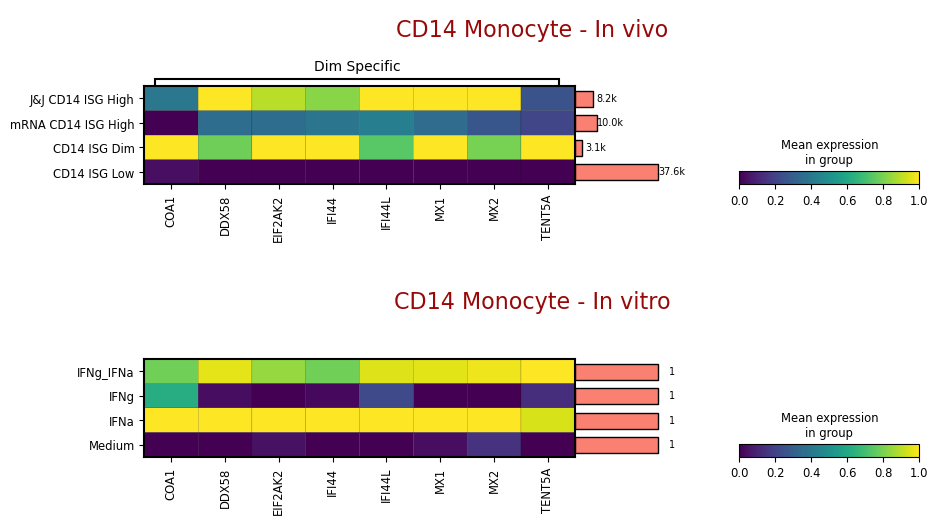

In [17]:
fig = plt.figure(figsize = (10, 5))
subfigs = fig.subfigures(nrows=2, wspace=0)


ax = subfigs[0].subplots()
mp = sc.pl.matrixplot(our_cd14, 
                      isg_dims, 
                      groupby = 'subsets', 
                      standard_scale = 'var',
                      return_fig=True,
                      var_group_rotation = 0,
                      ax = ax,
                      show = False
                     )
mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vivo', y = .8, fontsize=16, color = '#990808')
    # if ct != 'Naive CD8':
    #     mp.get_axes()['mainplot_ax'].set_xticklabels([])

ax = subfigs[1].subplots()
mp = sc.pl.matrixplot(adata[['IFNg_IFNa', 'IFNg', 'IFNa', 'Medium']], 
              sum(isg_dims.values(), []),
              groupby = 'Sample', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True,
              ax = ax
             )

mp = mp.add_totals().style(edge_color='black')
mp.make_figure()
ax.set_title('CD14 Monocyte - In vitro', y = .8, fontsize=16, color = '#990808')

fig = mp.fig


plt.show()

In [35]:
invivo_df = sc.get.obs_df(our_cd14, ['subsets', 'MX1', 'GBP2', 'GBP5', 'WARS']).groupby('subsets', observed=True).mean()

invitro_df_select = invitro_df.loc[['MX1', 'GBP2', 'GBP5', 'WARS'], ['IFNg_IFNa', 'IFNg', 'IFNa', 'Medium']].T
# invitro_df_select['subsets'] = invitro_df_select.index

In [36]:
# ratio = invitro_df_select.loc['Medium'] / invivo_df.loc['CD14 ISG Low']

In [37]:
def standart_scale(col, min=0, max=1):
    cur_max = col.max()
    cur_min = col.min()

    return (col - cur_min) / (cur_max - cur_min)

In [38]:
invitro_df_select_scaled = invitro_df_select.apply(standart_scale, axis=0)

In [39]:
invivo_df_scaled = invivo_df.apply(standart_scale, axis=0)

In [40]:
invitro_df_select_scaled, invivo_df_scaled

(Gene Name       MX1      GBP2      GBP5      WARS
 IFNg_IFNa  0.955915  0.874842  0.650520  1.000000
 IFNg       0.000000  1.000000  1.000000  0.851202
 IFNa       1.000000  0.454993  0.114347  0.377357
 Medium     0.031736  0.000000  0.000000  0.000000,
                          MX1      GBP2      GBP5      WARS
 subsets                                                   
 J&J CD14 ISG High   1.000000  0.883049  1.000000  1.000000
 mRNA CD14 ISG High  0.348499  1.000000  0.929577  0.975208
 CD14 ISG Dim        0.997276  0.234095  0.062778  0.129203
 CD14 ISG Low        0.000000  0.000000  0.000000  0.000000)

Text(0.5, 1.0, 'In Vitro Stimulation')

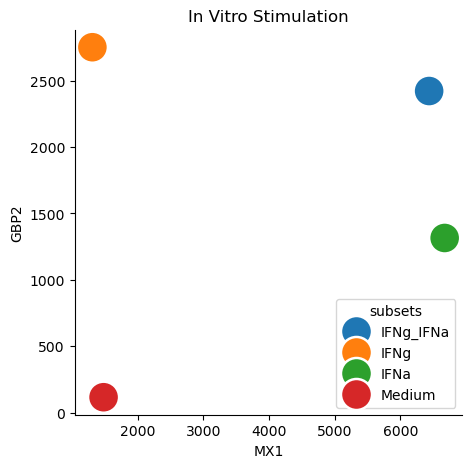

In [41]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.scatterplot(invitro_df_select.reset_index(names = 'subsets'), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 500, ax = ax)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('In Vitro Stimulation')

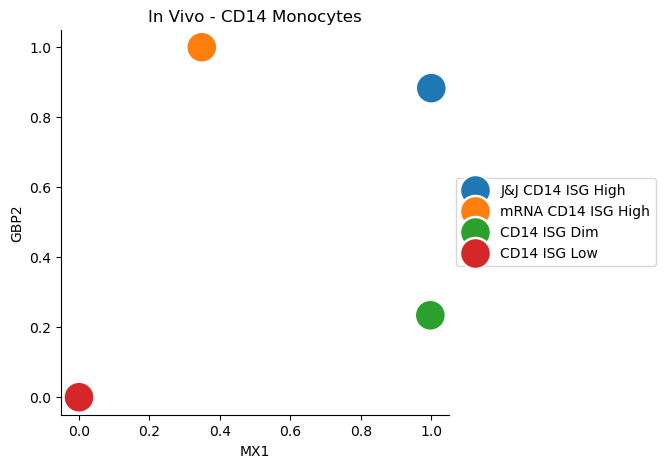

In [42]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.scatterplot(invivo_df_scaled.reset_index(names = 'subsets'), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 500, ax = ax)
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('In Vivo - CD14 Monocytes')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

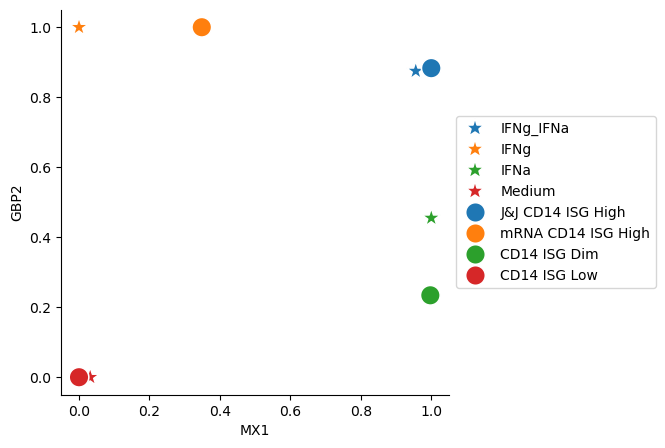

In [43]:
fig, ax = plt.subplots(ncols=1, figsize = (5, 5))
sns.scatterplot(invitro_df_select_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax, marker = '*')
sns.scatterplot(invivo_df_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

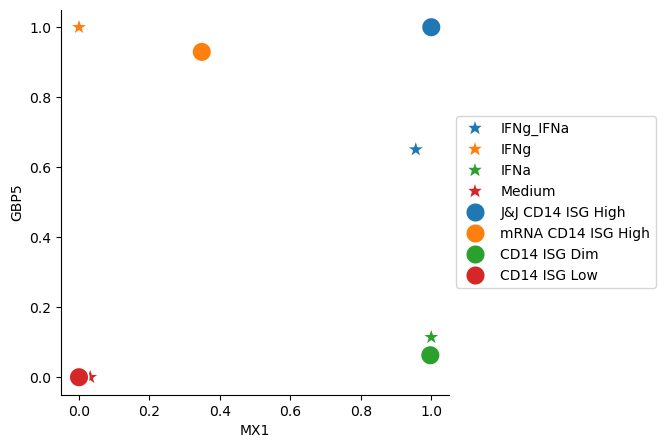

In [44]:
fig, ax = plt.subplots(ncols=1, figsize = (5, 5))
sns.scatterplot(invitro_df_select_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP5', hue = 'subsets', s = 200, ax = ax, marker = '*')
sns.scatterplot(invivo_df_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP5', hue = 'subsets', s = 200, ax = ax)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

# Add public data

In [165]:
balis_cd14 = sc.read_h5ad('/projects/ucar-lab/giray/DOGMA-seq/Dogma-2/Restart from aggregated samples/analysis/2021_BaliPulendranPaper/CD14-1_1.h5ad')

In [174]:
balis_cd14.X = balis_cd14.layers['normalized'].copy()

In [167]:
balis_cd14.obs['subsets'] = pd.Categorical('CD14 ' + balis_cd14.obs['subsets'].astype(str), categories=['CD14 ISG High', 'CD14 ISG Dim', 'CD14 ISG Low'])

In [175]:
balis_cd14_df = sc.get.obs_df(balis_cd14, ['subsets', 'MX1', 'GBP2']).groupby('subsets', observed=True).mean()
# invitro_df_select['subsets'] = invitro_df_select.index

In [171]:
balis_dc = sc.read_h5ad('/projects/ucar-lab/giray/DOGMA-seq/Dogma-2/Restart from aggregated samples/analysis/2021_BaliPulendranPaper/cDC2-1-c.h5ad')
balis_dc.X = balis_dc.layers['normalized'].copy()
balis_dc.obs['subsets'] = pd.Categorical(balis_dc.obs['subsets_2'].map({
    'cDC2': 'cDC2 ISG Low',
    'cDC2 ISG Dim': 'cDC2 ISG Dim',
    'cDC2 ISG High': 'cDC2 ISG High'
}), categories=['cDC2 ISG High', 'cDC2 ISG Dim', 'cDC2 ISG Low'])
balis_dc_df = sc.get.obs_df(balis_dc, ['subsets', 'MX1', 'GBP2']).groupby('subsets', observed=True).mean()

In [179]:
balis_cd14_df = balis_cd14_df.apply(standart_scale)
balis_dc_df = balis_dc_df.apply(standart_scale)

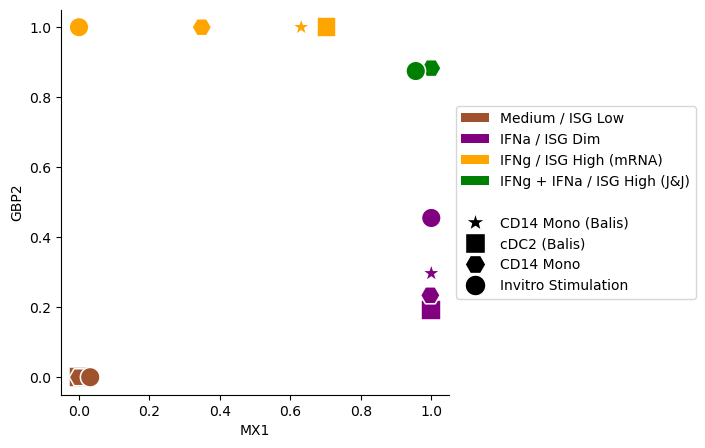

In [213]:
fig, ax = plt.subplots(ncols=1, figsize = (5, 5))
sns.scatterplot(balis_cd14_df.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax, marker = '*', 
                palette = {'CD14 ISG Low': 'sienna', 'CD14 ISG Dim': 'purple', 'CD14 ISG High': 'orange'})
sns.scatterplot(balis_dc_df.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax, marker = 's', 
                palette = {'cDC2 ISG Low': 'sienna', 'cDC2 ISG Dim': 'purple', 'cDC2 ISG High': 'orange'})
sns.scatterplot(invivo_df_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax, marker = 'H',
                palette = {'CD14 ISG Low': 'sienna', 'CD14 ISG Dim': 'purple', 'mRNA CD14 ISG High': 'orange', 'J&J CD14 ISG High': 'green'})
sns.scatterplot(invitro_df_select_scaled.reset_index(names = ['subsets']), x = 'MX1', y = 'GBP2', hue = 'subsets', s = 200, ax = ax, 
                palette = {'Medium': 'sienna', 'IFNa': 'purple', 'IFNg': 'orange', 'IFNg_IFNa': 'green'})
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['top', 'right']].set_visible(False)


legend_elements = [
    Patch(label='Medium / ISG Low', facecolor='sienna'),
    Patch(label='IFNa / ISG Dim', facecolor='purple'),
    Patch(label='IFNg / ISG High (mRNA)', facecolor='orange'),
    Patch(label='IFNg + IFNa / ISG High (J&J)', facecolor='green'),

    Line2D([0], [0], color='w', label=' ', markerfacecolor='k', markersize=15),

    Line2D([0], [0], marker='*', color='w', label='CD14 Mono (Balis)', markerfacecolor='k', markersize=15),
    Line2D([0], [0], marker='s', color='w', label='cDC2 (Balis)', markerfacecolor='k', markersize=15),
    Line2D([0], [0], marker='H', color='w', label='CD14 Mono', markerfacecolor='k', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Invitro Stimulation', markerfacecolor='k', markersize=15),
]
ax.legend(bbox_to_anchor = [1, 0.5], loc = 'center left', handles = legend_elements)